In [1]:
import os
import json
from model_functions import PaddedDataset, trainer_gpt2_transformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer


PATH_VOCAB = "../0_data/5_vocabs"
PATH_WORD_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_LOSS = "../0_data/7_models/loss"
PATH_MODELS_CONFIG = "../0_data/7_models/config"

for path in [PATH_MODELS, PATH_MODELS_LOSS, PATH_MODELS_CONFIG]:
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data

In [3]:
with open(f"{PATH_WORD_DATA}/d_data.json", 'r') as fp:
    json_data = json.load(fp)

song_list = []
for song in json_data:
    song_list.append(json_data[song])

data = [" ".join(song) for song in song_list]

split_train_test = int(0.9*len(data))
print("Data length:", len(data))
print("90% at:     ", split_train_test)
print()
print("Example data point:", data[0][:60])

Data length: 803
90% at:      722

Example data point: Bar_None Position_3/16 Note-On_76 Note-Duration_2 Position_4


# Tokeinzer

In [4]:
tokenizer = GPT2Tokenizer(
    vocab_file=f"{PATH_VOCAB}/vocab_d.json", 
    merges_file=f"{PATH_VOCAB}/merges.txt")

tokenizer.add_special_tokens({'pad_token': 'PAD', 'bos_token': 'BOS', 'eos_token': 'EOS',})

print("vocab size: ", tokenizer.vocab_size)
print("PAD token: ", tokenizer.pad_token_id)
print("BOS token: ", tokenizer.bos_token_id)
print("EOS token: ", tokenizer.eos_token_id)

vocab size:  88
PAD token:  88
BOS token:  89
EOS token:  90


# Model

In [5]:
model_df = pd.read_excel(f"{PATH_MODELS}/model_stats.xlsx", index_col="Unnamed: 0")
model_df

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,incorrect_notes,correct_notes,correct_rate
0,1_short_small_50,256,128,2,3,0.01,0.001,50,4,yes,185.6872,3.09,1.163706,50.0,0.0,65.8,1.00
1,2_short_medium_50,256,256,4,6,0.01,0.001,50,4,yes,286.7629,4.78,1.251897,24.0,0.2,70.4,1.00
2,3_short_large_50,256,512,8,12,0.01,0.001,50,4,yes,568.0452,9.47,1.973589,50.0,0.0,74.6,1.00
3,4_middle_small_50,1024,128,2,3,0.01,0.001,50,4,yes,248.7667,4.15,1.087204,50.0,0.0,264.8,1.00
4,5_middle_medium_50,1024,256,4,6,0.01,0.001,50,4,yes,628.1603,10.47,1.120312,40.0,0.2,265.6,1.00
5,6_middle_large_50,1024,512,8,12,0.01,0.001,50,4,yes,2247.7578,37.46,1.872430,48.0,0.4,289.8,1.00
6,7_long_small_50,2048,128,2,3,0.01,0.001,50,4,yes,491.8461,8.20,1.202734,50.0,1.6,546.8,1.00
7,8_long_medium_50,2048,256,4,6,0.01,0.001,50,4,yes,1506.3536,25.11,1.154148,37.0,2.8,526.8,0.99
8,9_long_large_50,2048,512,8,12,0.01,0.001,50,4,yes,5933.9392,98.90,1.284094,50.0,0.2,552.2,1.00
9,4_v1,1024,128,2,3,0.01,0.010,100,4,yes,489.4652,8.16,1.966235,91.0,0.2,253.4,1.00


/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.189400,1.993460
2,1.883900,1.881259
3,1.827600,1.853841
4,1.800400,1.849808
5,1.781100,1.816173
6,1.762200,1.802349
7,1.733900,1.766807
8,1.609700,1.445141
9,1.395100,1.331100
10,1.333000,1.290972


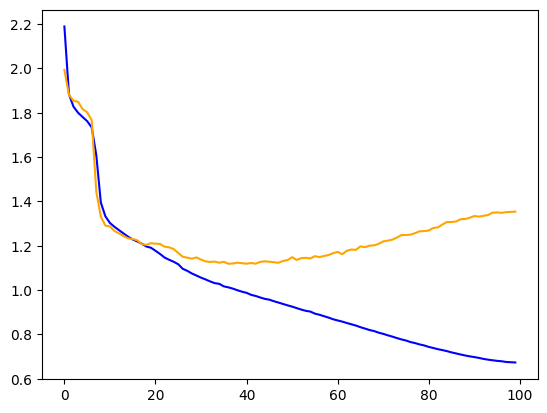

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.252800,1.947494
2,1.866800,1.875659
3,1.814800,1.851541
4,1.796700,1.835020
5,1.779300,1.812649
6,1.755400,1.821362
7,1.742000,1.815581
8,1.732500,1.799155
9,1.693600,1.689974
10,1.536900,1.435107


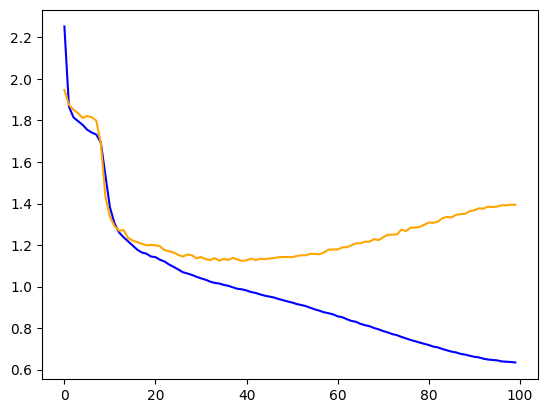

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.533400,2.027544
2,1.908200,1.926136
3,1.836200,1.866625
4,1.812900,1.850852
5,1.803300,1.842031
6,1.771700,1.819208
7,1.764800,1.825523
8,1.751500,1.807544
9,1.736600,1.797118
10,1.721900,1.783912


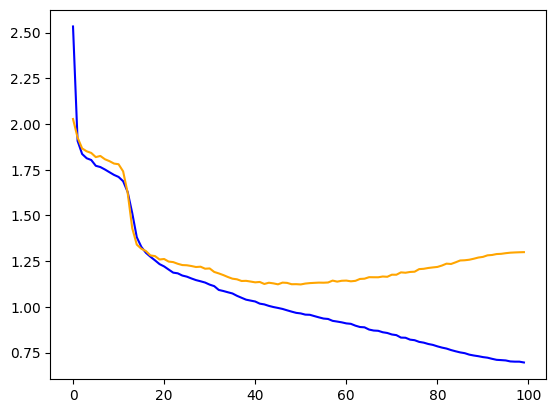

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,incorrect_notes,correct_notes,correct_rate
0,1_short_small_50,256,128,2,3,0.01,0.001,50,4,yes,185.6872,3.09,1.163706,50.0,0.0,65.8,1.00
1,2_short_medium_50,256,256,4,6,0.01,0.001,50,4,yes,286.7629,4.78,1.251897,24.0,0.2,70.4,1.00
2,3_short_large_50,256,512,8,12,0.01,0.001,50,4,yes,568.0452,9.47,1.973589,50.0,0.0,74.6,1.00
3,4_middle_small_50,1024,128,2,3,0.01,0.001,50,4,yes,248.7667,4.15,1.087204,50.0,0.0,264.8,1.00
4,5_middle_medium_50,1024,256,4,6,0.01,0.001,50,4,yes,628.1603,10.47,1.120312,40.0,0.2,265.6,1.00
5,6_middle_large_50,1024,512,8,12,0.01,0.001,50,4,yes,2247.7578,37.46,1.872430,48.0,0.4,289.8,1.00
6,7_long_small_50,2048,128,2,3,0.01,0.001,50,4,yes,491.8461,8.20,1.202734,50.0,1.6,546.8,1.00
7,8_long_medium_50,2048,256,4,6,0.01,0.001,50,4,yes,1506.3536,25.11,1.154148,37.0,2.8,526.8,0.99
8,9_long_large_50,2048,512,8,12,0.01,0.001,50,4,yes,5933.9392,98.90,1.284094,50.0,0.2,552.2,1.00
9,4_v1,1024,128,2,3,0.01,0.010,100,4,yes,489.4652,8.16,1.966235,91.0,0.2,253.4,1.00


In [6]:
rows = []

for index, row in model_df.iterrows():
    
    # only run models that not ran yet
    if row["ran"] == "yes":
        continue
    
    # create model name directories
    model_name = row["name"]
    model_dirs = {
        "loss": f"{PATH_MODELS_LOSS}/{model_name}",
        "out": f"{PATH_MODELS_CONFIG}/{model_name}"
    }
    for key in model_dirs:
        if not os.path.exists(model_dirs[key]):
            os.makedirs(model_dirs[key])
    
    # save hyperparameters as dictionary
    model_hyperparameters = {
        "max_length": row["max_length"],
        "emb_dim": row["emb_dim"],
        "attention_heads": row["attention_heads"],
        "layers": row["layers"],
        "dropout": row["dropout"],
        "learning_rate": row["learning_rate"],
        "epochs": row["epochs"],
        "batch_size": row["batch_size"],
    }
    
    # create datasets and define data collator
    train_dataset = PaddedDataset(tokenizer=tokenizer, data=data[:split_train_test], max_length=row["max_length"])
    eval_dataset = PaddedDataset(tokenizer=tokenizer, data=data[split_train_test:], max_length=row["max_length"])
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    model_data = {
        "train_dataset": train_dataset,
        "eval_dataset": eval_dataset,
        "data_collator": data_collator,
    }
    
    # create and train model trainer
    trainer = trainer_gpt2_transformer(
        hyperparameters = model_hyperparameters,
        tokenizer = tokenizer,
        data = model_data,
        dirs = model_dirs,
    )
    
    trainer.train()
    
    
    # save runtime and model loss
    log_hist = trainer.state.log_history
    eval_loss = [log_hist[i]["eval_loss"] for i in range(1,len(log_hist),2)]
    train_loss = [log_hist[i]["loss"] for i in range(0,len(log_hist)-1,2)]
    runtime = log_hist[-1]["train_runtime"]
    
    model_df.at[index,"runtime"] = runtime
    model_df.at[index,"runtime_min"] = (runtime/60).__round__(2)
    model_df.at[index,"min_loss"] = min(eval_loss)
    model_df.at[index,"at_epoch"] = np.argmin(eval_loss) + 1

    # show loss plot
    plt.plot(train_loss, color="blue")
    plt.plot(eval_loss, color="orange")
    plt.savefig(f"{model_dirs['loss']}/loss_graph_{model_name}.jpg")
    plt.show()
    
    # save model and set ran to yes
    trainer.save_model(f"{model_dirs['out']}/end_version")
    model_df.at[index,"ran"] = "yes"
    
model_df

In [7]:
model_df.to_excel(f"{PATH_MODELS}/model_stats.xlsx")